<a href="https://colab.research.google.com/github/dgansen/Cup-Of-Excellence-Data/blob/master/Unit1Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTS
import pandas as pd
from google.colab import files
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# KEY OBJECTS AND FUNCTIONS
countries = {'Bolivia':[2009,2008,2007,2005,2004],
             'Brazil':[2019,2018,2017,2016,'December2015','January2015',2014,2013,2012],
             'Brazil Pulped':[2018,2017,2016,2015,2014,2013,2012,2011,
                                       2009,2008,2006,2005,2004,2003],
             'Burundi':[2019,2018,2017,2015,2014,2013,2012],
             'Colombia':['North2019',2018,2017,'North2015','South2014',
                         'North2013','South2012','North2011','South2010',
                         'North2009','South2008','North2007','North2006',
                         'South2006','North2005','South2005'],
             'Costa Rica':[2019,2018,2017,2016,2015,2014,2013,2012,2011,2009,2008,2007],
             'El Salvador':[2019,2018,2017,2015,2014,2013,2012,2011,2010,2009,
                            2008,2007,2006,2005,2004,2003],
             'Guatemala':[2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,
                          2008,2007,2006],
             'Honduras':[2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,
                         2008,2007,2006,2005,2004],
             'Mexico':[2019,2018,2017,2015,2014,2013,2012],
             'Nicaragua':[2018,2017,2015,2014,2012,2011,2010,2009,2008,2007,2006,
                          2005,2004,2003],
             'Peru':[2019,2018,2017],
             'Rwanda':[2018,2015,2014,2013,2012,2011,2010,2008]}
#Roughly North to South order for the countries
hue_order = ['Mexico','Guatemala','Honduras','El Salvador','Nicaragua',
             'Costa Rica','Colombia','Rwanda','Burundi','Brazil','Brazil Pulped','Peru','Bolivia']
problems = {'RANK':'OBJRANK',
            'SIZE(30KGBOXES)':'SIZE',
            'FARM/CWS':'FARM',
            'NOME':'FARM',
            'FARMER':'FARMER/REPRESENTATIVE',
            'OWNER':'FARMER/REPRESENTATIVE',
            'PRODUCER':'FARMER/REPRESENTATIVE',
            'LOTNO':'DROP',
            'BID':'HIGH_BID',
            'HIGHBID':'HIGH_BID',
            'TOTALVALUE':'TOTAL_VALUE',
            'COMPANYNAME':'BUYERS',
            'HIGHBIDDER':'BUYERS',
            'HIGHBIDDER(S)':'BUYERS',
            'PROCESSING':'PROCESS'}

def clean_dollars (string):
  return pd.to_numeric(string.str.strip('$/lb').str.replace(',',''))
def clean_cols (dataframe):
  #Returns DataFrame with uniform column titles
  cols = dataframe.columns
  dataframe.columns = cols.str.strip(' .#').str.upper().str.replace(' ','')
  dataframe = dataframe.rename(columns=problems)
  #Check for cols that need dropping
  if (dataframe.columns=='DROP').any():
    dataframe.drop(columns='DROP',inplace=True)
  return dataframe


# Raw Columns found in WINNING FARMS
#RANK | SIZE            | FARM / CWS | FARMER / REPRESENTATIVE | REGION | SCORE
#     |WEIGHT (kg)      |    FARM    | FARMER                  |        |      |VARIETY|PROCESS
#     |                 |  FARM/CWS  | OWNER                   |        |      |       |
#     |                 |            |                         |        |      |       |       |LOT NO.
#Rank |Weight (kg)      |    Farm    | Farmer                  | Region | Score|Variety|Process
#     |SIZE (30KG BOXES)|            | Producer                |        |      |       |
# Desired columns:
# OBJRANK | NUMRANK | WEIGHT(KG) | FARM | FARMER/REPRESENTATIVE | REGION | SCORE | VARIETY | PROCESS

# Raw Columns found in COE AUCTION RESULTS
#  LOT #   | WINNING FARM / CWS |	 LOT SIZE  |	HIGH BID |	TOTAL VALUE |	HIGH BIDDER(S)
#   Rank   |      Farm          |Weight(lbs.)| High bid  | Total Value  | Company Name
#   Lot #  | Winning Farm / CWS |     X      |           |        |Commissions| High Bidder(s)
#Lot Number|      Farm Name     | Quantity   |           |              |
#          |     FARM/CWS       |            |           |              |
#       |Score|Boxes|-----------|Weight      |   Bid     | Total value|Farm| High Bidder
#          |                    |  Lot Size  | High Bid  |              |
# Desired columns (contributing)
# HIGH_BID | TOTAL_VALUE | BUYERS

# GOALS(TODO)
#- Search for distance from equator by region
#- Find similar info for big coffee countries not found here (Ethiopia, Kenya)
#- Do judges show a preference?
#- Variety, Process come from where, when, and how are their scores?
#- why Pulped? it's a processing method that intially was held as a different 
#     event than the true naturals. At some point, fold these together.
#- Does the risk in natural processing usually pay off?
#- Recent weather patterns for that region

In [4]:
# FORM MASTER DATA SET
master = pd.DataFrame(columns=['OBJRANK', 'WEIGHT(KG)', 'FARM', 'FARMER/REPRESENTATIVE', 'REGION',
       'SCORE', 'VARIETY', 'PROCESS', 'NUMRANK', 'HIGH_BID', 'TOTAL_VALUE',
       'BUYERS', 'COUNTRY', 'YEAR'])
count = 0
for country in countries:
  years = countries[country]
  print(count,'of 13 countries loaded',flush=True)
  for year in years:
    # Read in
    url = 'https://raw.githubusercontent.com/dgansen/Cup-Of-Excellence-Data/master/' + country.replace(' ','%20') + '/' + country.replace(' ','') + str(year) + '%20-%20Sheet1.csv'
    url_auction = 'https://raw.githubusercontent.com/dgansen/Cup-Of-Excellence-Data/master/' + country.replace(' ','%20') + '/' + country.replace(' ','') + str(year) + 'Auction%20-%20Sheet1.csv'
    dfL = pd.read_csv(url)
    dfR = pd.read_csv(url_auction,na_values='–')

    #Clean col titles
    dfL = clean_cols(dfL)
    dfR = clean_cols(dfR)

    #Clean dollar signs, make numeric (HIGH BID, TOTAL VALUE)
    dfR['HIGH_BID'] = clean_dollars(dfR['HIGH_BID'])
    dfR['TOTAL_VALUE'] = clean_dollars(dfR['TOTAL_VALUE'])

    #Convert SIZE to WEIGHT(KG)
    if not (dfL.columns=='WEIGHT(KG)').any():
      #Catch the weird one in Colombia 2018
      if dfL['SIZE'].dtype == 'O':
        dfL['SIZE'] = pd.to_numeric(dfL['SIZE'].str.lower().str.replace(r'\('+r'\+'+'1 partial'+r'\)',''))

      dfL['SIZE'] = dfL['SIZE'] * 30
      dfL = dfL.rename(columns={'SIZE':'WEIGHT(KG)'})
    #Fix WEIGHT(KG) to become all numeric
    elif dfL['WEIGHT(KG)'].dtype == 'O':
      dfL['WEIGHT(KG)'] = pd.to_numeric(dfL['WEIGHT(KG)'].str.replace(',',''))
    
    #Check for bad vals making it past cleaning
    #if dfL.isna().any().any():
    #  print('NAs in ',country,year)
    #if dfR.isna().any().any():
    #  print('NAs in ',country,year,' Auction')
    if dfL['SCORE'].dtype == 'O':
      dfL['SCORE'] = pd.to_numeric(dfL['SCORE'].str.strip('$'))

    #Fill VARIETY, PROCESS if none
    if not (dfL.columns==('VARIETY' or 'PROCESS')).any():
      dfL['VARIETY'] = np.nan
      dfL['PROCESS'] = np.nan
    else:
      #Clean VARIETY, PROCESS
      dfL['VARIETY'] = dfL['VARIETY'].str.title().str.strip('.#')
      dfL['PROCESS'] = dfL['PROCESS'].str.title().str.strip('.#')

    
    #Add NUMRANK column
    if dfL['OBJRANK'].dtype == np.object:
      dfL['NUMRANK'] = pd.to_numeric(dfL['OBJRANK'].str.replace(r"[a-zA-Z]",''))#[^0-9]+
    else:
      dfL['NUMRANK'] = pd.to_numeric(dfL['OBJRANK'])

    #Join check for the one where several lots were stolen (wild story)
    if len(dfL) == len(dfR):
      df = dfL.join(dfR[['HIGH_BID','TOTAL_VALUE','BUYERS']])
    else:
      dfR = dfR.rename(columns={'LOT':'OBJRANK'})
      df = pd.merge(dfL,dfR[['OBJRANK','HIGH_BID','TOTAL_VALUE','BUYERS']],how='inner',on='OBJRANK')
    
    #Add column for country and year
    df['COUNTRY'] = country
    df['YEAR'] = year if type(year)==int else pd.to_numeric(year.strip('DecemberJanuaryNorthSouth'))

    #If OBJRANK contains a/b, sum the two weight rows
    #todo

    #Append to master dataset
    master = master.append(df,ignore_index=True) 
  count+=1
master['NUMRANK'] = pd.to_numeric(master['NUMRANK'])
master['WEIGHT(KG)'] = pd.to_numeric(master['WEIGHT(KG)'])
master['YEAR'] = pd.to_numeric(master['YEAR'])
print(count,'of 13 countries loaded',flush=True)

0 of 13 countries loaded
1 of 13 countries loaded
2 of 13 countries loaded
3 of 13 countries loaded
4 of 13 countries loaded
5 of 13 countries loaded
6 of 13 countries loaded
7 of 13 countries loaded
8 of 13 countries loaded
9 of 13 countries loaded
10 of 13 countries loaded
11 of 13 countries loaded
12 of 13 countries loaded
13 of 13 countries loaded


In [5]:
print(master.shape)
master.head()

(3899, 14)


,OBJRANK,WEIGHT(KG),FARM,FARMER/REPRESENTATIVE,REGION,SCORE,VARIETY,PROCESS,NUMRANK,HIGH_BID,TOTAL_VALUE,BUYERS,COUNTRY,YEAR
0,1,720.0,Agrotakesi SA,Mauricio Ramiro Diez de Medina,"Yanacahi, Yungas of La Paz",93.36,NaN,NaN,1,35.05,63749.29,"Maruyama Coffee for Mikatajuku Group, Itoya Co...",Bolivia,2009
1,2,840.0,Café Sima del Jaguar A,Braulio Luque Yana,"Caranavi, Yungas of La Paz",92.05,NaN,NaN,2,12.06,25614.60,"Time’s Club for C-COOP, Tashiro Coffee",Bolivia,2009
2,3,690.0,Café Monterrey,Valentin Choquehuanca Aduviri,"Caranavi, Yungas of La Paz",91.62,NaN,NaN,3,9.20,16011.04,"Coffee Bean International, Inc",Bolivia,2009
3,4,600.0,Café Jacaranda,Cruz Elias Choconapi,"Caranavi, Yungas of La Paz",91.38,NaN,NaN,4,12.80,18779.90,"UCC Ueshima Coffee Co., Ltd.",Bolivia,2009
4,5,630.0,Café Alan Coffe,Luis Yujra Arismende,"Caranavi, Yungas of La Paz",90.90,NaN,NaN,5,12.35,19657.99,49th Parallel Coffee Roasters and Cafe Imports,Bolivia,2009


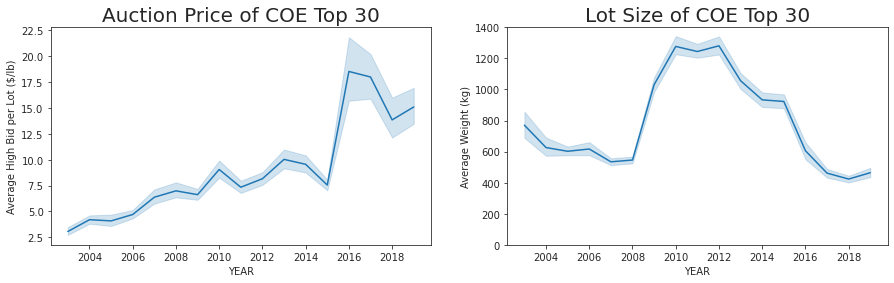

In [12]:
# VISUALIZATIONS
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
fontdict = {'fontsize':20}
sns.set_style(style='ticks')

fig.sca(ax1)
ax1 = sns.lineplot(data=master,x='YEAR',y='HIGH_BID')
ax1.set_ylabel('Average High Bid per Lot ($/lb)')
ax1.set_title('Auction Price of COE Top 30',fontdict=fontdict)
fig.sca(ax2)
ax2 = sns.lineplot(data=master, x='YEAR',y='WEIGHT(KG)')
ax2.set_ylim(0,1400)
ax2.set_title('Lot Size of COE Top 30',fontdict=fontdict)
ax2.set_ylabel('Average Weight (kg)');

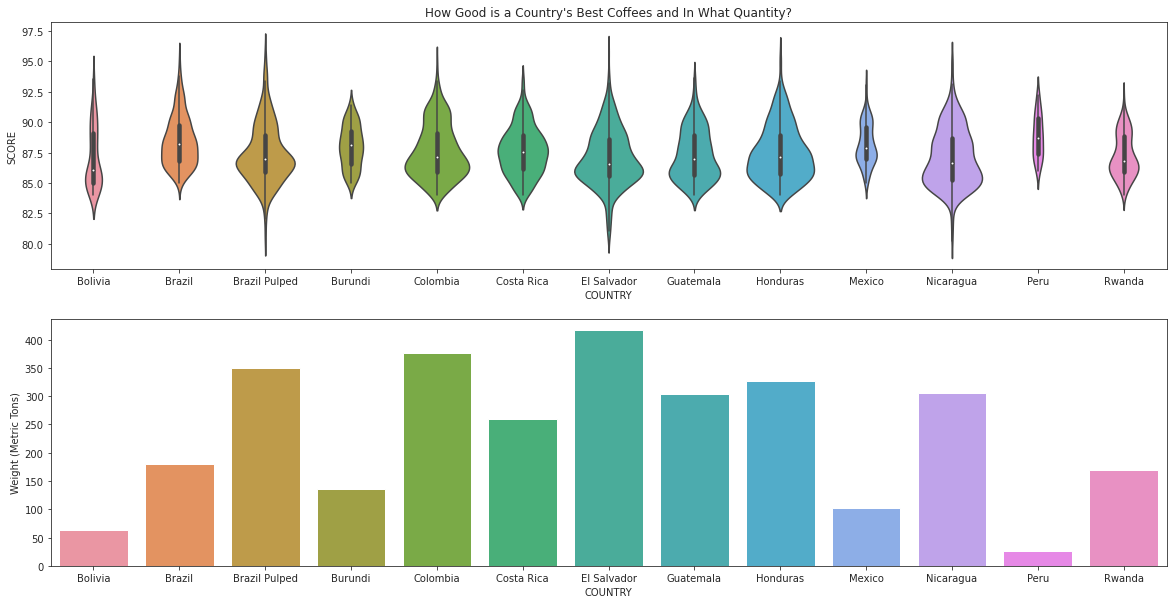

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.sca(ax1)
fig.set_figwidth(20)
fig.set_figheight(10)
ax1 = sns.violinplot(data=master,x='COUNTRY',y='SCORE',scale='count')
ax1.set_title("How Good is a Country's Best Coffees and In What Quantity?")

fig.sca(ax2)
sum_by_country = master.groupby(['COUNTRY']).sum()
ax2 = sns.barplot(data=sum_by_country,x=sum_by_country.index,y='WEIGHT(KG)')
ax2.set_ylabel('Weight (Metric Tons)')
ax2.set_yticklabels(range(0,401,50));


In [0]:
# single chart pull for troubleshooting
country = 'Honduras'
year = '2009'
url = 'https://raw.githubusercontent.com/dgansen/Cup-Of-Excellence-Data/master/' + country.replace(' ','%20') + '/' + country.replace(' ','') + str(year) + '%20-%20Sheet1.csv'
url_auction = 'https://raw.githubusercontent.com/dgansen/Cup-Of-Excellence-Data/master/' + country.replace(' ','%20') + '/' + country.replace(' ','') + str(year) + 'Auction%20-%20Sheet1.csv'
dfL = pd.read_csv(url)
dfR = pd.read_csv(url_auction,na_values='–')
#round((clean_dollars(dfR['Total Value']) / clean_dollars(dfR['High Bid'])) - clean_dollars(dfR['Weight (lbs.)']))
dfL = clean_cols(dfL)
dfR = clean_cols(dfR)
dfR = dfR.rename(columns={'LOT':'OBJRANK'})
